# Predictive Project: Forecasting BBRI Stock
- Nama: Mohammad Valeriant Qumara Tanda
- ID: MC180D5Y0566
- Email: valenttanda@gmail.com

## Import library
Import library yang dibutuhkan untuk proyek ini. Pada proyek ini, akan menggunakan library berikut:
- `pandas`: Mengolah data. 
- `numpy`: Melakukan operasi matematika.
- `matplotlib`: Membuat grafik.
- `seaborn`: Untuk membuat grafik yang lebih menarik.
- `tensorflow`: Membuat model neural network yang digunakan untuk prediksi.
- `scikit-learn`: Membuat model machine learning yang digunakan untuk prediksi (untuk kasus ini, tidak digunakan karena menggunakan tensorflow). scikit-learn hanya digunakan pada proses preprocessing dan evaluasi model.

In [126]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

## Load Dataset
Mengambil dataset dari sumber yang telah ditentukan. Dataset yang digunakan dalam proyek ini adalah dataset yang diambil dari laman [Yahoo Finance](https://finance.yahoo.com/quote/BBRI.JK/) yang berisi data harga saham PT. Bank Rakyat Indonesia (Persero) Tbk pada 5 tahun terakhir dengan menggunakan teknik ETL (_Extract, Transform, Load_).

In [127]:
df = pd.read_csv('BBRI_Stock.csv', sep=',', parse_dates=['Date'], index_col='Date', header=0)
df

,Unnamed: 0,Open,High,Low,Close
Date,,,,,
2020-01-02,0,2954.129281,2960.843262,2927.273539,2960.843262
2020-01-03,1,2967.557129,2980.985090,2947.415367,2967.557129
2020-01-06,2,2927.273812,2947.415575,2900.418067,2933.987793
2020-01-07,3,2960.843620,2960.843620,2940.701856,2954.129639
2020-01-08,4,2940.701660,2954.129442,2913.845917,2940.701660
...,...,...,...,...,...
2025-05-19,1294,4230.000000,4260.000000,4200.000000,4230.000000
2025-05-20,1295,4230.000000,4280.000000,4170.000000,4210.000000
2025-05-21,1296,4210.000000,4310.000000,4210.000000,4260.000000


## EDA
Di tahap ini, akan dilakukan analisis exploratory data (EDA) untuk memahami data yang ada. EDA ini bertujuan untuk memahami distribusi data, hubungan antar variabel, dan menemukan pola-pola yang ada dalam data. Berikut adalah langkah-langkah yang dilakukan pada tahap EDA:

### 1. Dataset information
Berisikan informasi mengenai dataset yang digunakan. Informasi ini meliputi:
- Bentuk dataset: Mengetahui jumlah kolom dan baris dalam dataset
- Informasi dataset: Mengetahui jenis data yang ada dalam dataset, seperti numerik, kategori, atau tanggal, dan secara tidak langsung mengetahui adakah nilai yang hilang dalam dataset atau tidak
- Statistik dataset: Mengetahui nilai rata-rata, median, dan modus dari dataset

Cek Bentuk Dataset

In [128]:
df.shape

(1299, 5)

Cek Informasi Dataset

In [129]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1299 entries, 2020-01-02 to 2025-05-23
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  1299 non-null   int64  
 1   Open        1299 non-null   float64
 2   High        1299 non-null   float64
 3   Low         1299 non-null   float64
 4   Close       1299 non-null   float64
dtypes: float64(4), int64(1)
memory usage: 60.9 KB


Handling dataset:
- Drop column: Unnamed:  <br>
Alasan: Kolom ini tidak memiliki informasi yang relevan untuk analisis.

Cek Statistik Dataset

In [131]:
df.describe()

,Unnamed: 0,Open,High,Low,Close
count,1299.00000,1299.000000,1299.000000,1299.000000,1299.000000
mean,649.00000,3642.747562,3683.988330,3599.348660,3638.742866
std,375.13331,862.856098,866.923796,863.150443,865.874889
min,0.00000,1569.563790,1583.515653,1506.781310,1513.757202
25%,324.50000,3035.464170,3063.600554,3000.061126,3023.755615
50%,649.00000,3660.223043,3709.243743,3610.000000,3650.000000
75%,973.50000,4313.875548,4363.246057,4280.838748,4308.603516
max,1298.00000,5763.100219,5785.969664,5694.491883,5763.100098


Cek Duplikasi Dataset

In [132]:
print(f"Duplicated data: {df.duplicated().sum()}")

Duplicated data: 0


### 2. Handling dataset:
Karena dataset yang digunakan sudah bersih, maka penanganan dataset hanya menghapus kolom yang tidak relevan untuk analisis mendatang.

1. Drop column: Unnamed: 0

In [133]:
df = df.drop(columns=['Unnamed: 0'])
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1299 entries, 2020-01-02 to 2025-05-23
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    1299 non-null   float64
 1   High    1299 non-null   float64
 2   Low     1299 non-null   float64
 3   Close   1299 non-null   float64
dtypes: float64(4)
memory usage: 50.7 KB


### 3.  Data Visualization
Visualisasi data dilakukan untuk memahami pola dan tren data. Dalam proyek ini, saya menggunakan library `matplotlib` dan `seaborn` untuk membuat grafik yang menampilkan distribusi nilai-nilai data, serta hubungan antara variabel-variabel. Sebelum melakukan visualisasi, pastikan hanya data numerik yang digunakan.

Memastikan hanya data numerik yang digunakan untuk visualisasi

In [134]:
numerical = df.select_dtypes(include=np.number)
numerical 

,Open,High,Low,Close
Date,,,,
2020-01-02,2954.129281,2960.843262,2927.273539,2960.843262
2020-01-03,2967.557129,2980.985090,2947.415367,2967.557129
2020-01-06,2927.273812,2947.415575,2900.418067,2933.987793
2020-01-07,2960.843620,2960.843620,2940.701856,2954.129639
2020-01-08,2940.701660,2954.129442,2913.845917,2940.701660
...,...,...,...,...
2025-05-19,4230.000000,4260.000000,4200.000000,4230.000000
2025-05-20,4230.000000,4280.000000,4170.000000,4210.000000
2025-05-21,4210.000000,4310.000000,4210.000000,4260.000000


**Correlation between features** <br>
Mengecek korelasi antar fitur numerik dapat membantu dalam menemukan hubungan antara fitur-fitur tersebut. Dengan menggunakan metode korelasi, kita dapat mengetahui apakah ada hubungan antara fitur-fitur tersebut yang dapat membantu dalam proses klasifikasi.

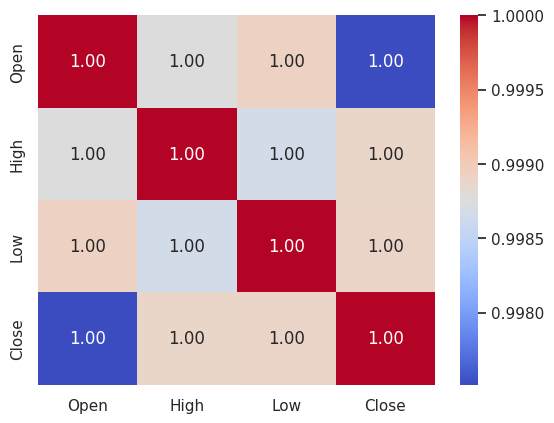

In [135]:
sns.heatmap(numerical.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.show()

Stock over time<br>
Mengecek arah pergerakan harga saham berdasarkan Open, High, Low, dan Close selama 5 tahun terakhir

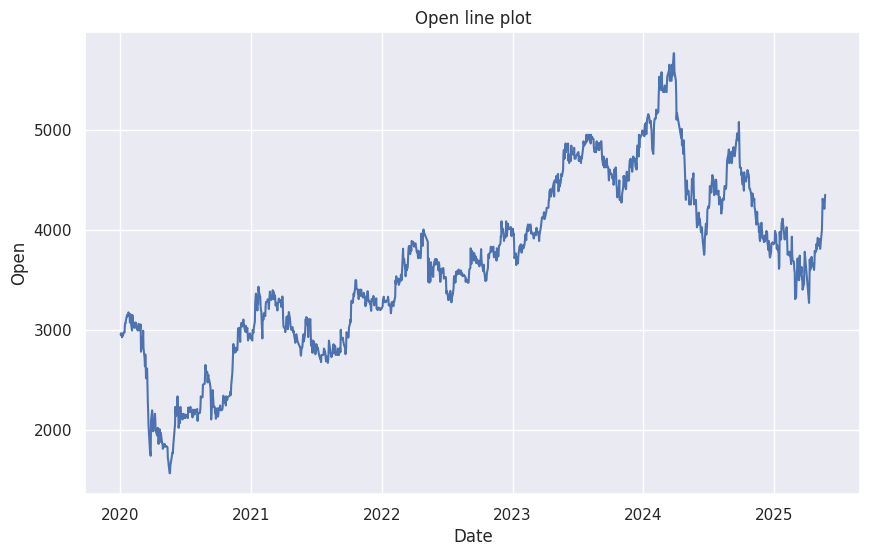

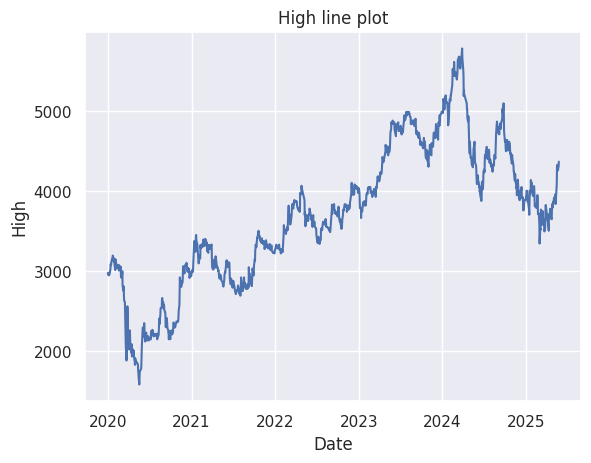

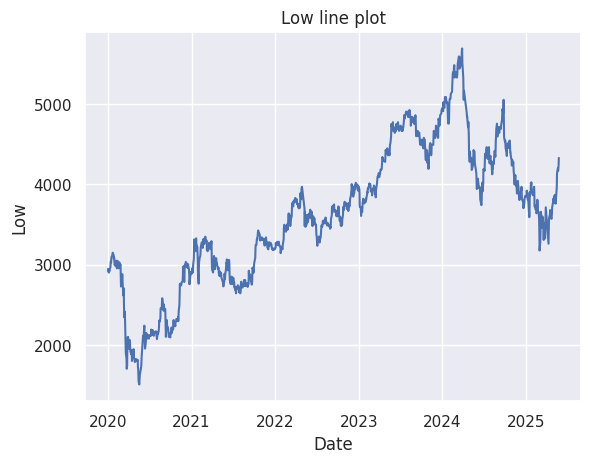

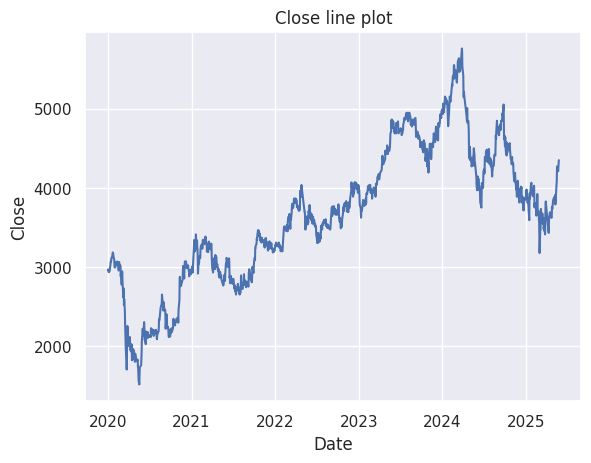

In [136]:
plt.figure(figsize=(10,6))
for col in numerical:
  sns.lineplot(data=df, x='Date', y=col)
  plt.title(f"{col} line plot")
  plt.show()

Histogram<br>
Mengecek distribusi data numerik untuk melihat persebaran data, dan menghitung kemiringan distribusi dengan `scipy`

<Figure size 1400x800 with 0 Axes>

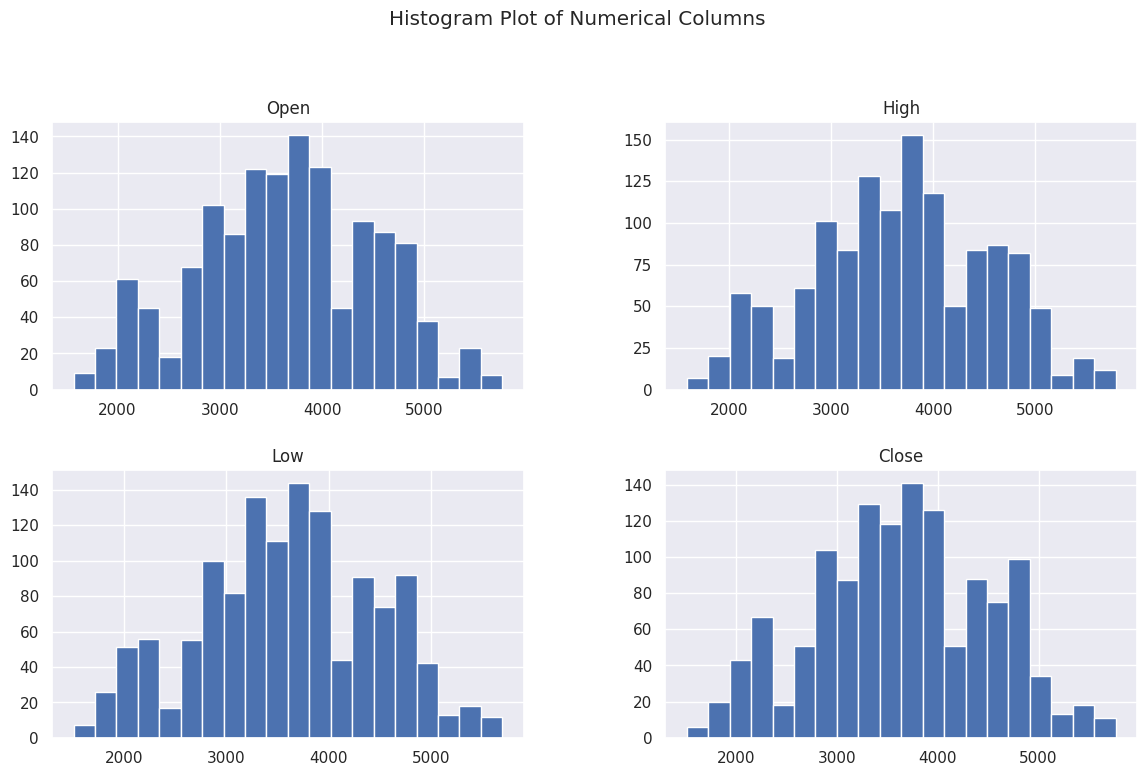

Skewness Open: -0.06
Skewness High: -0.044
Skewness Low: -0.068
Skewness Close: -0.057


In [137]:
from scipy.stats import skew
sns.set(style="darkgrid")
plt.figure(figsize=(14,8))
numerical.hist(figsize=(14,8), bins=20)
plt.suptitle("Histogram Plot of Numerical Columns", y=1.02)
plt.show()

# Skewness Count
for column in numerical:
  if (df[column].dtype == 'object') or (df[column].nunique() == 2):
    continue
  print(f"Skewness {column}: {skew(df[column]).round(3)}")

Pairplot<br>
Melihat persebaran data dari 2 fitur berbeda

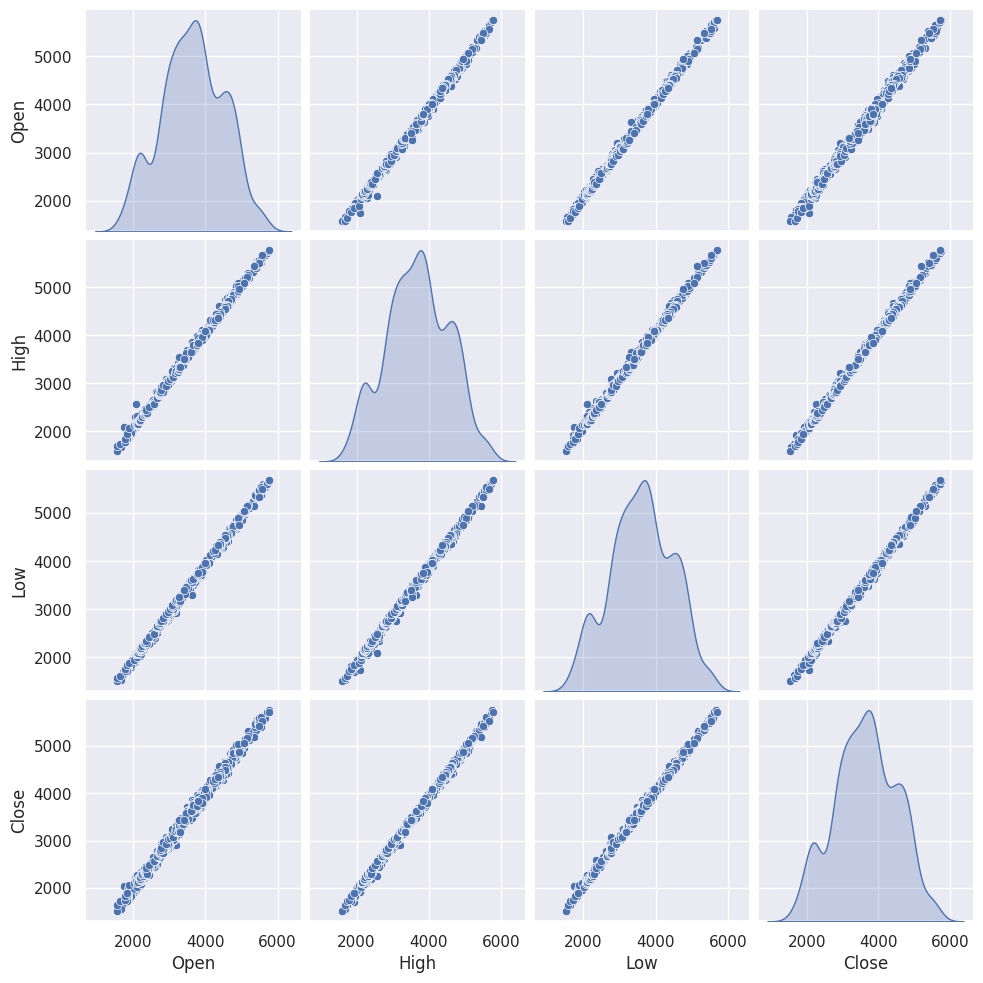

In [138]:
sns.pairplot(numerical, diag_kind='kde')
plt.show()

Boxplot<br>
Mengetahui rata-rata persebaran data dan mengecek adakah outlier pada suatu data atau tidak

Statistics for column Open: 
 <bound method NDFrame.describe of Date
2020-01-02    2954.129281
2020-01-03    2967.557129
2020-01-06    2927.273812
2020-01-07    2960.843620
2020-01-08    2940.701660
                 ...     
2025-05-19    4230.000000
2025-05-20    4230.000000
2025-05-21    4210.000000
2025-05-22    4280.000000
2025-05-23    4350.000000
Name: Open, Length: 1299, dtype: float64>


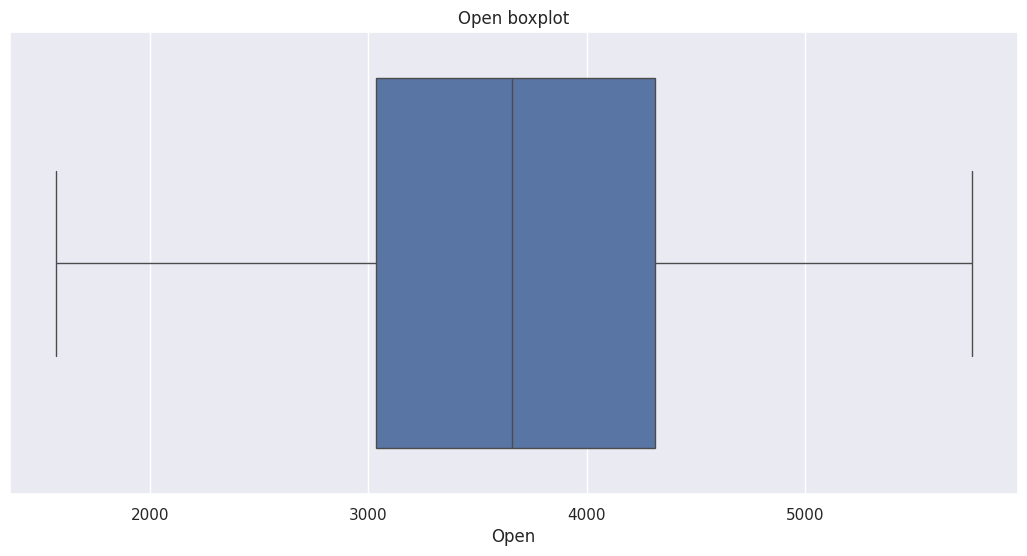

Statistics for column High: 
 <bound method NDFrame.describe of Date
2020-01-02    2960.843262
2020-01-03    2980.985090
2020-01-06    2947.415575
2020-01-07    2960.843620
2020-01-08    2954.129442
                 ...     
2025-05-19    4260.000000
2025-05-20    4280.000000
2025-05-21    4310.000000
2025-05-22    4310.000000
2025-05-23    4370.000000
Name: High, Length: 1299, dtype: float64>


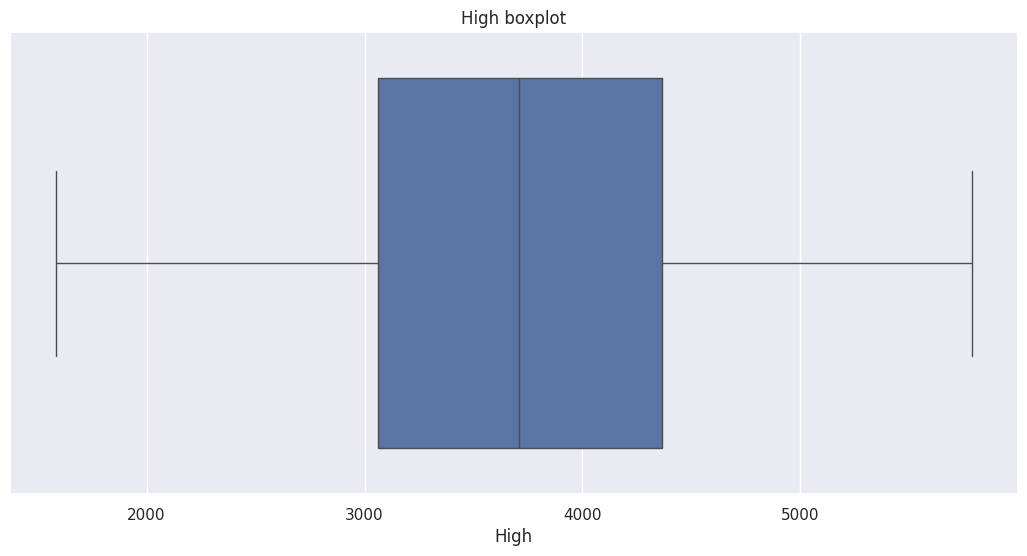

Statistics for column Low: 
 <bound method NDFrame.describe of Date
2020-01-02    2927.273539
2020-01-03    2947.415367
2020-01-06    2900.418067
2020-01-07    2940.701856
2020-01-08    2913.845917
                 ...     
2025-05-19    4200.000000
2025-05-20    4170.000000
2025-05-21    4210.000000
2025-05-22    4240.000000
2025-05-23    4330.000000
Name: Low, Length: 1299, dtype: float64>


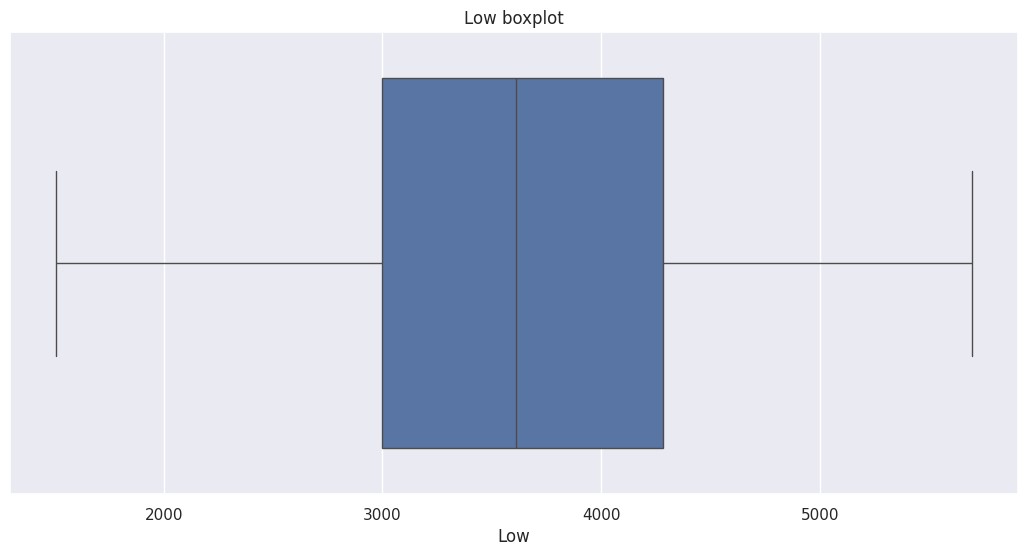

Statistics for column Close: 
 <bound method NDFrame.describe of Date
2020-01-02    2960.843262
2020-01-03    2967.557129
2020-01-06    2933.987793
2020-01-07    2954.129639
2020-01-08    2940.701660
                 ...     
2025-05-19    4230.000000
2025-05-20    4210.000000
2025-05-21    4260.000000
2025-05-22    4300.000000
2025-05-23    4350.000000
Name: Close, Length: 1299, dtype: float64>


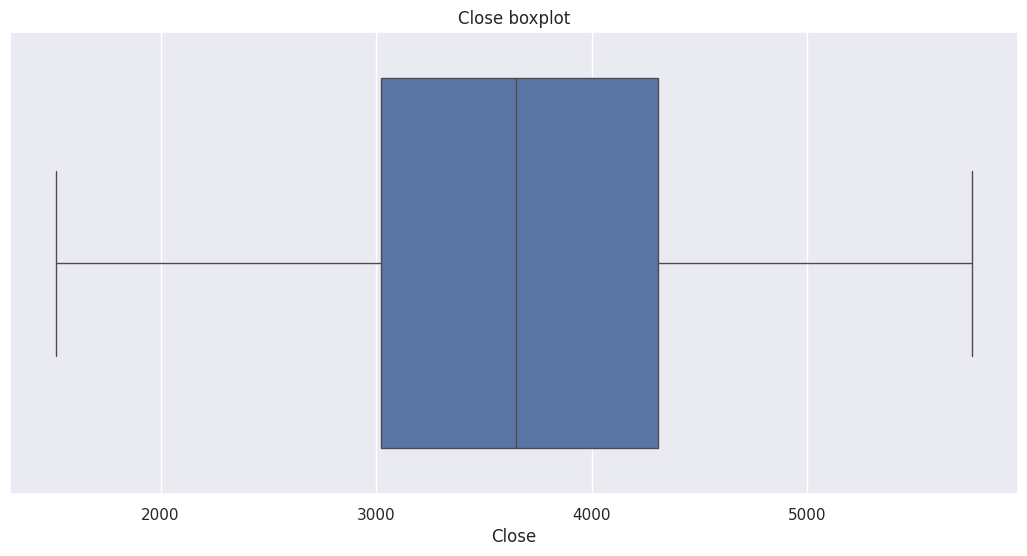

In [139]:
for col in numerical:
  print(f"Statistics for column {col}: \n", df[col].describe)
  plt.figure(figsize=(13,6))
  sns.boxplot(x=df[col])
  plt.title(f'{col} boxplot')
  plt.show()

## Preprocessing
Di tahap ini, data yang telah dikumpulkan akan diolah dan disiapkan untuk digunakan dalam model. Tahap ini meliput **Normalization** dan **Sliding Windowing**

Menyalin dataset awal ke dataset untuk preprocessing

In [140]:
df_preprocessed = df.copy()

### 1. Normalization
Normalisasi semua data numerik dengan menggunakan fungsi `StandardScaler` dari library `sklearn.preprocessing`. Ini akan mengubah skala data menjadi standar (0-1), sehingga nilai-nilai dapat dibandingkan secara lebih akurat.

In [141]:
# Normalize the 'Close' column using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Reshape the 'Close' column to 2D as required by MinMaxScaler
close_data = df_preprocessed['Close'].values.reshape(-1, 1)

# Fit and transform the data
close_scaled = scaler.fit_transform(close_data)

# Add the scaled data back to the DataFrame (optional, for reference)
df_preprocessed['Close_scaled'] = close_scaled

# Verify the scaling
print("Original Close range:", df_preprocessed['Close'].min(), "to", df_preprocessed['Close'].max())
print("Scaled Close range:", df_preprocessed['Close_scaled'].min(), "to", df_preprocessed['Close_scaled'].max())

Original Close range: 1513.7572021484375 to 5763.10009765625
Scaled Close range: 0.0 to 1.0


### 2. Sliding Windowing
Melakukan teknik sliding windowing untuk mempercepat proses pengolahan data. Teknik ini melibatkan penggunaan jendela yang bergerak untuk memproses data secara berkelompok. Selain itu, tahap ini juga memisahkan data menjadi data latih dan data uji dengan proporsi 80:20

In [142]:
# Function to create sequences for supervised learning
def create_sequences(data, lookback=60):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i + lookback])  # Sequence of 'lookback' time steps
        y.append(data[i + lookback])    # Next time step
    return np.array(X), np.array(y)

# Prepare the scaled data
lookback = 60  # Number of past days to use for prediction
data_scaled = df_preprocessed['Close_scaled'].values  # Use the scaled data
X, y = create_sequences(data_scaled, lookback)

# Split into train and test sets (e.g., 80% train, 20% test)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape X for LSTM [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (991, 60, 1)
y_train shape: (991,)
X_test shape: (248, 60, 1)
y_test shape: (248,)


## Modeling
Di tahap ini, data yang telah melalui preprocessing dan dipisah menjadi data latih dan data uji, kemudian digunakan untuk membuat dan melatih model forecasting. Model yang digunakan adalah model **LSTM** dan **MLP**.

### 1. LSTM Model
Long-Short Term Memory (LSTM) adalah model yang digunakan untuk memprediksi nilai yang akan datang dari data waktu. LSTM dapat digunakan untuk memprediksi nilai yang akan datang dari data waktu dengan menggunakan informasi dari beberapa waktu yang lalu. Hal yang dikerjakan untuk membuat model LSTM adalah sebagai berikut:
1. Pembuatan arsitektur model LSTM
2. Melatih model LSTM
3. Menguji model LSTM
4. Hasil evaluasi model LSTM dengan RMSE, MAE, dan MAPE
5. Visualisasi hasil prediksi dari model LSTM terhadap nilai aktual

1. Membuat arsitektur model

In [143]:
# LSTM Model
model_lstm = Sequential([
  LSTM(100, return_sequences=True, input_shape=(lookback, 1)),
  Dropout(0.2),
  LSTM(100),
  Dense(50, activation='relu'),
  Dropout(0.2),
  BatchNormalization(),
  Dense(1)
])
model_lstm.summary()

/home/valenttanda/forecast/.env/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 60, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 50)             │           200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 126,501 (494.14 KB)

 Trainable params: 126,401 (493.75 KB)

 Non-trainable params: 100 (400.00 B)

2. Fungsi callback untuk menghentikan proses pelatihan ketika model mencapai akurasi tertinggi

In [144]:
# Callback
callback = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
            tf.keras.callbacks.ModelCheckpoint(filepath='best_model.keras', monitor='val_loss', save_best_only=True)]

3. Melatih model

In [145]:
model_lstm.compile(loss='mae', optimizer='adam', metrics=["mae"])
history_lstm = model_lstm.fit(X_train, y_train, epochs=100, callbacks=callback, batch_size=32, validation_split=0.1, verbose=1)

Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - loss: 0.4297 - mae: 0.4297 - val_loss: 0.5264 - val_mae: 0.5264
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 0.1134 - mae: 0.1134 - val_loss: 0.3667 - val_mae: 0.3667
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - loss: 0.0589 - mae: 0.0589 - val_loss: 0.3835 - val_mae: 0.3835
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0622 - mae: 0.0622 - val_loss: 0.3719 - val_mae: 0.3719
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 0.0608 - mae: 0.0608 - val_loss: 0.3772 - val_mae: 0.3772
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 0.0484 - mae: 0.0484 - val_loss: 0.3615 - val_mae: 0.3615
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 0.0501 - mae: 0.0501 - val_loss: 0.3477 - val_mae: 0.3477
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 0.0490 - mae: 0.0490 - val_loss: 0.3890 - val_mae: 0.3890
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - lo

#### Model Evaluation
Di tahap ini, model yang telah dilatih akan di uji dengan data uji. Dari hasil pengujian, selanjutnya model dievaluasi dengan menggunakan beberapa metrik evaluasi, yaitu RMSE, MAE, dan MAPE

Prediction<br>
Menguji hasil pelatihan model dengan data uji

In [146]:
# Predict on test set
pred_lstm_scaled = model_lstm.predict(X_test)

# Inverse-transform the predictions and actual values
y_test_2d = y_test.reshape(-1, 1)  # Ensure 2D shape for scaler
pred_lstm_2d = pred_lstm_scaled.reshape(-1, 1)

y_test_unscaled = scaler.inverse_transform(y_test_2d)
pred_lstm_unscaled = scaler.inverse_transform(pred_lstm_2d)

# Flatten for consistency
y_test_unscaled = y_test_unscaled.flatten()
pred_lstm_unscaled = pred_lstm_unscaled.flatten()

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step


Evaluation<br>
Mengukur hasil uji model dengan metrik RMSE, MAE, dan MAPE

In [147]:
rmse_lstm_unscaled = np.sqrt(mean_squared_error(y_test_unscaled, pred_lstm_unscaled))
mae_lstm_unscaled = mean_absolute_error(y_test_unscaled, pred_lstm_unscaled)
mape_lstm_unscaled = mean_absolute_percentage_error(y_test_unscaled, pred_lstm_unscaled) * 100
print(f"RMSE: {rmse_lstm_unscaled:.4f}")
print(f"MAE: {mae_lstm_unscaled:.4f}")
print(f"MAPE: {mape_lstm_unscaled:.4f}%")

RMSE: 135.8427
MAE: 108.0573
MAPE: 2.6813%


Visualization<br>
Visualisasi hasil uji model terhadap nilai aktual

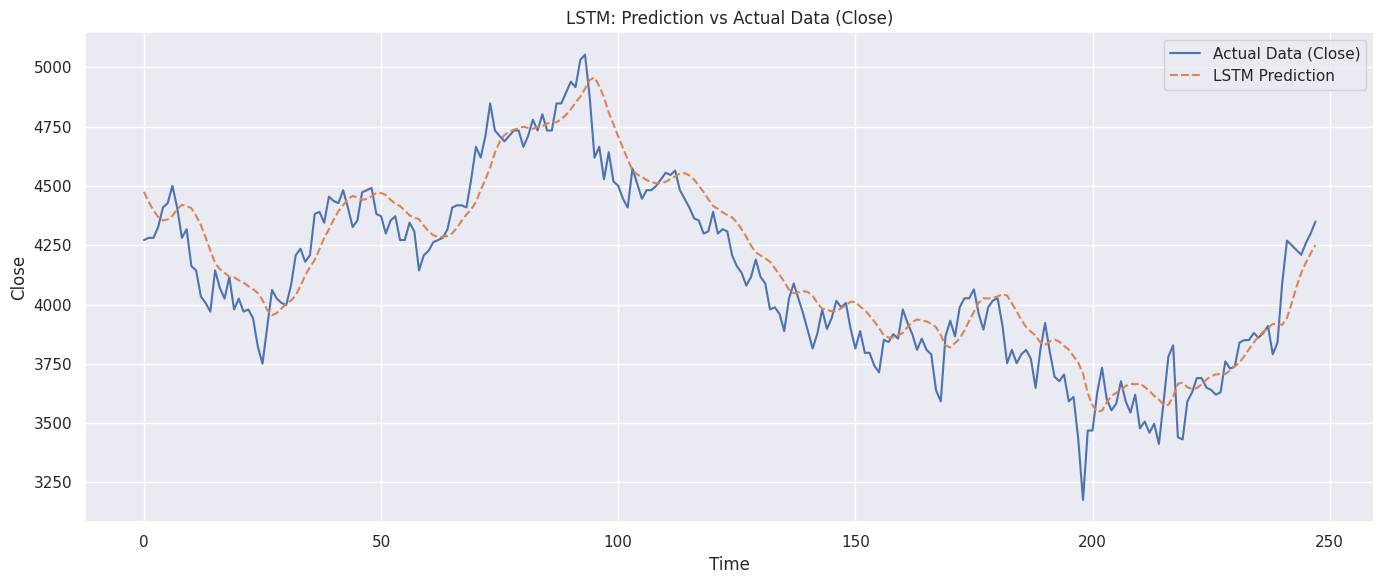

In [148]:
plt.figure(figsize=(14, 6))
plt.plot(y_test_unscaled[:300], label="Actual Data (Close)")
plt.plot(pred_lstm_unscaled[:300], label="LSTM Prediction", linestyle='--')
plt.title("LSTM: Prediction vs Actual Data (Close)")
plt.xlabel("Time")
plt.ylabel("Close")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### 2. MLP Model

MultiLayer Perceptron (MLP) adalah model yang paling umum digunakan dalam deep learning. MLP terdiri dari beberapa layer yang masing-masing terdiri dari beberapa neuron. Setiap neuron memiliki beberapa input dan output. Hal yang dikerjakan untuk membuat model MLP adalah sebagai berikut:
1. Pembuatan arsitektur model MLP
2. Melatih model MLP
3. Menguji model MLP
4. Hasil evaluasi model MLP dengan RMSE, MAE, dan MAPE
5. Visualisasi hasil prediksi dari model MLP terhadap nilai aktual

1. Membuat arsitektur model

In [149]:
# Flatten the input for MLP
X_train_mlp = X_train.reshape((X_train.shape[0], X_train.shape[1] * X_train.shape[2]))
X_test_mlp = X_test.reshape((X_test.shape[0], X_test.shape[1] * X_test.shape[2]))

model_mlp = Sequential([
  Dense(100, input_shape=(lookback,), kernel_regularizer=tf.keras.regularizers.l2(0.01)),
  Dropout(0.2),
  Dense(50, activation='relu'),
  Dropout(0.2),
  BatchNormalization(),
  Dense(1)
])
model_mlp.summary()

/home/valenttanda/forecast/.env/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_22 (Dense)                │ (None, 100)            │         6,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 50)             │           200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,401 (44.54 KB)

 Trainable params: 11,301 (44.14 KB)

 Non-trainable params: 100 (400.00 B)

2. Fungsi callback untuk menghentikan proses pelatihan ketika model mencapai akurasi tertinggi

In [150]:
# Callback
callback = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
            tf.keras.callbacks.ModelCheckpoint(filepath='best_model.keras', monitor='val_loss', save_best_only=True)]

3. Melatih model

In [151]:
model_mlp.compile(loss='mae', optimizer='adam', metrics=["mae"])
history_mlp = model_mlp.fit(X_train_mlp, y_train, epochs=100, callbacks=callback, batch_size=32, validation_split=0.1, verbose=1)

Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.5335 - mae: 0.7943 - val_loss: 1.6528 - val_mae: 0.9273
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.2452 - mae: 0.5254 - val_loss: 1.0936 - val_mae: 0.3924
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2193 - mae: 0.5247 - val_loss: 0.9704 - val_mae: 0.2959
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0684 - mae: 0.4006 - val_loss: 0.8838 - val_mae: 0.2367
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9950 - mae: 0.3551 - val_loss: 0.8899 - val_mae: 0.2724
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9157 - mae: 0.3059 - val_loss: 0.6614 - val_mae: 0.0748
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8372 - mae: 0.2584 - val_loss: 0.6156 - val_mae: 0.0601
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7860 - mae: 0.2383 - val_loss: 0.7528 - val_mae: 0.2286
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.70

#### Model Evaluation
Di tahap ini, model yang telah dilatih akan di uji dengan data uji. Dari hasil pengujian, selanjutnya model dievaluasi dengan menggunakan beberapa metrik evaluasi, yaitu RMSE, MAE, dan MAPE

Prediction<br>
Menguji hasil pelatihan model dengan data uji

In [152]:
# Predict on test set
pred_mlp_scaled = model_mlp.predict(X_test_mlp)

# Inverse-transform the predictions and actual values
pred_mlp_2d = pred_mlp_scaled.reshape(-1, 1)

y_test_unscaled = scaler.inverse_transform(y_test_2d)  # Reuse y_test_unscaled from LSTM
pred_mlp_unscaled = scaler.inverse_transform(pred_mlp_2d)

# Flatten for consistency
pred_mlp_unscaled = pred_mlp_unscaled.flatten()

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


Evaluation<br>
Mengukur hasil uji model dengan metrik RMSE, MAE, dan MAPE

In [153]:
rmse_mlp_unscaled = np.sqrt(mean_squared_error(y_test_unscaled, pred_mlp_unscaled))
mae_mlp_unscaled = mean_absolute_error(y_test_unscaled, pred_mlp_unscaled)
mape_mlp_unscaled = mean_absolute_percentage_error(y_test_unscaled, pred_mlp_unscaled) * 100
print(f"RMSE: {rmse_mlp_unscaled:.4f}") 
print(f"MAE: {mae_mlp_unscaled:.4f}") 
print(f"MAPE: {mape_mlp_unscaled:.4f}%") 

RMSE: 190.5955
MAE: 149.9760
MAPE: 3.5904%


Visualization<br>
Visualisasi hasil uji model terhadap nilai aktual

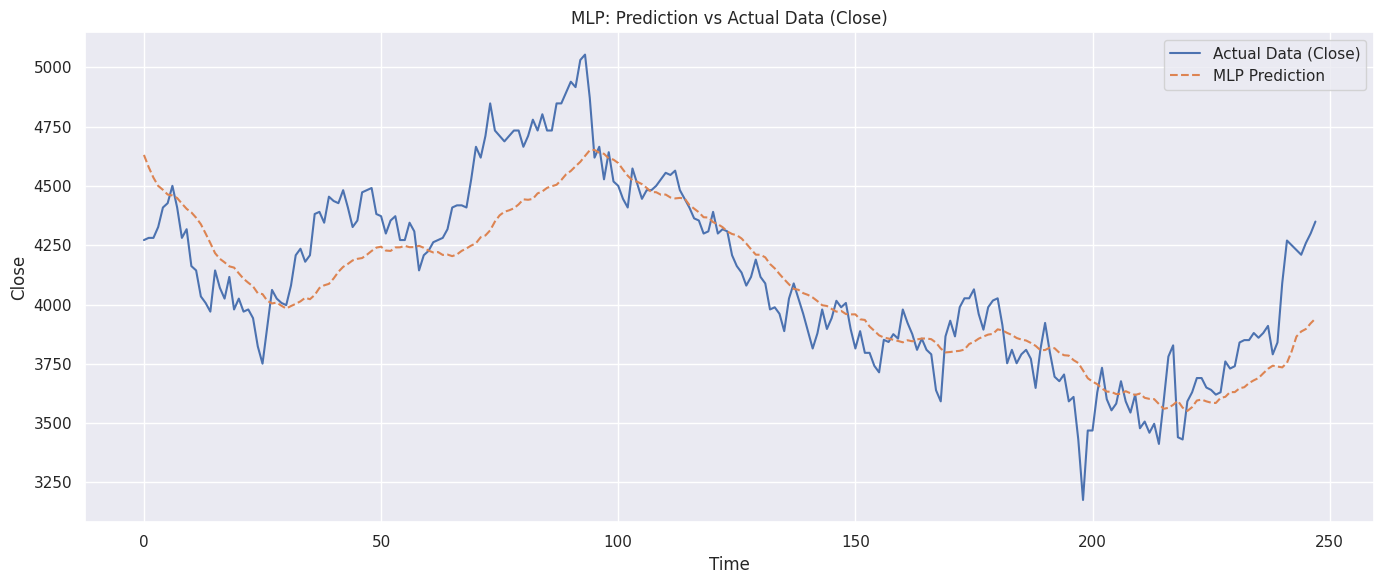

In [154]:
plt.figure(figsize=(14, 6))
plt.plot(y_test_unscaled[:300], label="Actual Data (Close)")
plt.plot(pred_mlp_unscaled[:300], label="MLP Prediction", linestyle='--')
plt.title("MLP: Prediction vs Actual Data (Close)")
plt.xlabel("Time")
plt.ylabel("Close")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Model Comparison
Hasil evaluasi dari kedua model kemudian dibandingkan untuk mengetahui mana yang lebih baik. Berikut adalah hasil evaluasi dari kedua model:

Membandingkan semua metrik yang digunakan untuk evaluasi kedua model

In [155]:
# Gather all the metrics
metrics = pd.DataFrame({
	'metric': ['RMSE', 'MAE', 'MAPE (%)'],
 	'LSTM': [f"{rmse_lstm_unscaled:.4f}", f"{mae_lstm_unscaled:.4f}", f"{mape_lstm_unscaled:.4f}"],
  'MLP': [f"{rmse_mlp_unscaled:.4f}", f"{mae_mlp_unscaled:.4f}", f"{mape_mlp_unscaled:.4f}"],
})
metrics

,metric,LSTM,MLP
0,RMSE,135.8427,190.5955
1,MAE,108.0573,149.9760
2,MAPE (%),2.6813,3.5904


Visualisasi perbandingan hasil pelatihan kedua model terhadap data aktual

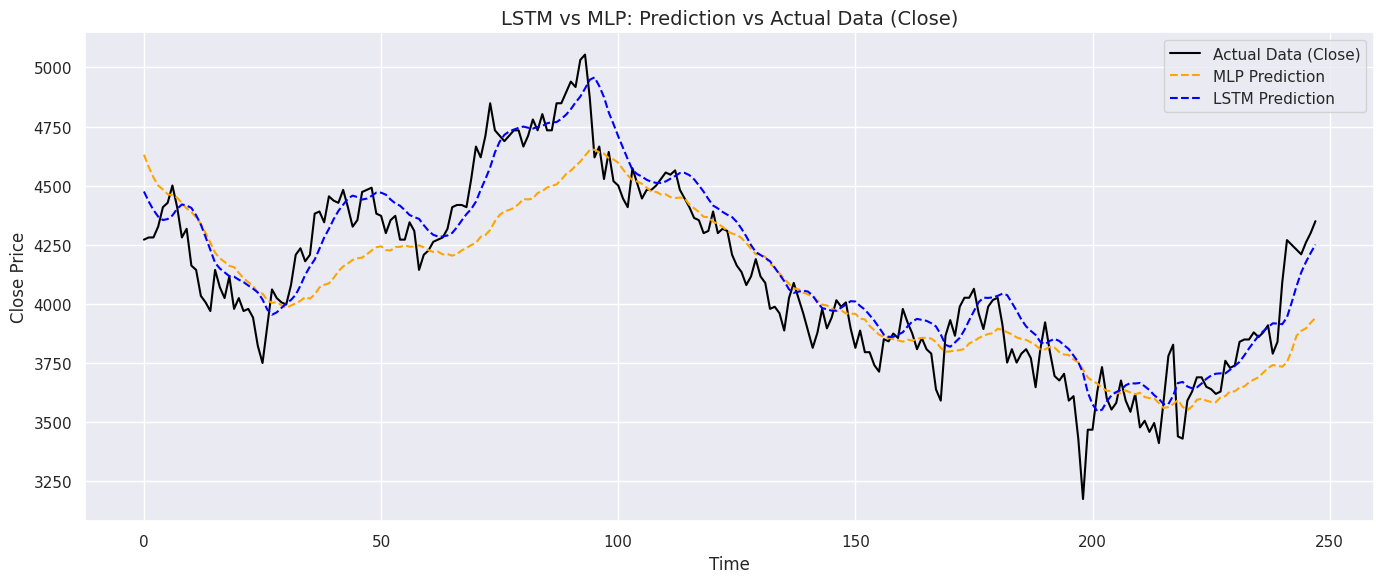

In [156]:
# Visualize Actual vs Predicted for LSTM and MLP
plt.figure(figsize=(14, 6))

# Plot actual data (either LSTM or MLP true_close)
plt.plot(y_test_unscaled[:300], label="Actual Data (Close)", color='black', linestyle='-')

# Plot MLP predictions
plt.plot(pred_mlp_unscaled[:300], label="MLP Prediction", color='orange', linestyle='--')

# Plot LSTM predictions
plt.plot(pred_lstm_unscaled[:300], label="LSTM Prediction", color='blue', linestyle='--')

# Add labels, title, and legend
plt.title("LSTM vs MLP: Prediction vs Actual Data (Close)", fontsize=14)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Close Price", fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

## Forecasting
Di tahap ini, model yang sudah dilatih dan diuji, kemudian digunakan untuk melakukan prediksi pergerakan harga saham BBRI untuk 30 hari kedepan

### LSTM Model

Mempersiapkan data yang dibutuhkan untuk melakukan forecasting dengan model LSTM

In [157]:
# Forecast future values
future_days = 30
last_sequence = data_scaled[-lookback:].reshape(1, lookback, 1)  # Shape for LSTM
future_forecast_lstm = []

# Iteratively predict future values
for _ in range(future_days):
    lstm_pred = model_lstm.predict(last_sequence)
    future_forecast_lstm.append(lstm_pred[0, 0])
    # Update sequence
    last_sequence = np.roll(last_sequence, -1, axis=1)
    last_sequence[0, -1, 0] = lstm_pred[0, 0]

# Inverse-transform the forecast
future_forecast_lstm_2d = np.array(future_forecast_lstm).reshape(-1, 1)
future_forecast_lstm_unscaled = scaler.inverse_transform(future_forecast_lstm_2d).flatten()

# Create future dates
last_date = pd.to_datetime(df_preprocessed.index[-1])
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=future_days, freq='B')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━

### MLP Model

Mempersiapkan data yang dibutuhkan untuk melakukan forecasting dengan model MLP

In [158]:
# Forecast future values for MLP
last_sequence_mlp = data_scaled[-lookback:].reshape(1, -1)  # Shape for MLP
future_forecast_mlp = []

# Iteratively predict future values
for _ in range(future_days):
    mlp_pred = model_mlp.predict(last_sequence_mlp)
    future_forecast_mlp.append(mlp_pred[0, 0])
    # Update sequence
    last_sequence_mlp = np.roll(last_sequence_mlp, -1)
    last_sequence_mlp[0, -1] = mlp_pred[0, 0]

# Inverse-transform the forecast
future_forecast_mlp_2d = np.array(future_forecast_mlp).reshape(-1, 1)
future_forecast_mlp_unscaled = scaler.inverse_transform(future_forecast_mlp_2d).flatten()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━

Visualisasi hasil forecasting untuk 30 hari kedepan dari kedua model

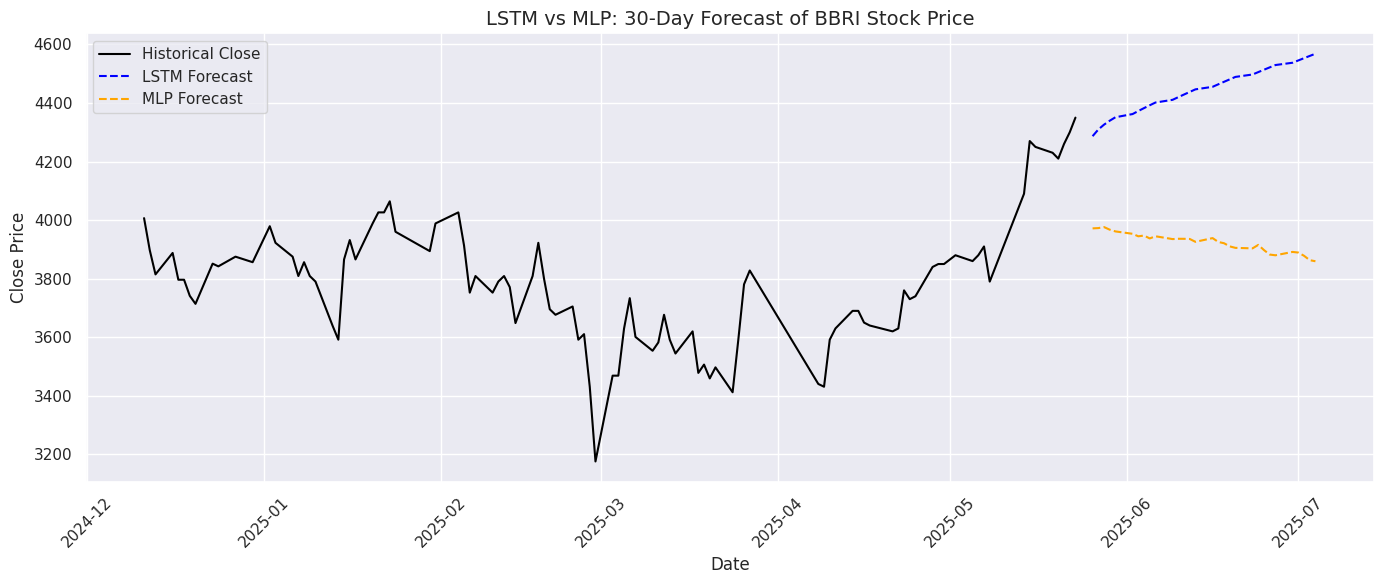

In [159]:
# Plot historical data and forecasts
plt.figure(figsize=(14, 6))
plt.plot(df.index[-100:], df['Close'][-100:], label="Historical Close", color='black')
plt.plot(future_dates, future_forecast_lstm_unscaled, label="LSTM Forecast", color='blue', linestyle='--')
plt.plot(future_dates, future_forecast_mlp_unscaled, label="MLP Forecast", color='orange', linestyle='--')
plt.title("LSTM vs MLP: 30-Day Forecast of BBRI Stock Price", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Close Price", fontsize=12)
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()